In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import nibabel as nib
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow_addons as tfa
import glob
import scipy

In [2]:
def window_image(img, minn,maxx, intercept, slope, rescale=True):
    img = (img*slope +intercept) 
    
    img[img<minn] = minn 
    img[img>maxx] = maxx 
    if rescale: 
        img = (img - minn) / (maxx - minn)
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value,
                    data[('0028','1051')].value,
                    data[('0028','1052')].value,
                    data[('0028','1053')].value]
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [3]:
def channeling(img1, img2, img3):
    return np.stack([img1, img2, img3], axis=-1)

In [4]:
def load_image(path):
    data_path = '../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_images/'
    UID = path.split('/')[-1][:-7]+"/"
    data = dcm.dcmread(data_path+UID+os.listdir(data_path+UID)[0])
    _, _, intercept, slope = get_windowing(data)
    img = nib.load(path)
    img = img.get_fdata()
    return img, intercept, slope

In [5]:
# def extract(path):
   
#     final_ct = load_image(path+"/"+"1.dcm").reshape(1,size,size)
#     for image in range(1, len(os.listdir(path))):
#         img = load_image(path+"/"+str(image)+".dcm").reshape(1,size,size)
#         final_ct = np.append(final_ct, img, axis=0)
        
#     resized_final_ct = cv2.resize(final_ct[:,:,0], (size,size)).reshape(1,size,size)
#     for i in range(1,final_ct.shape[1]):
#         resized_final_ct = np.append(resized_final_ct, cv2.resize(final_ct[:,:,i], (size,size)).reshape(1,size,size), axis=0)
  

#     return window(resized_final_ct)

In [6]:
bb_df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train.csv")


In [7]:
bb_df[['x', 'y', 'width', 'height']] = (bb_df[['x', 'y', 'width', 'height']]//2).astype(int)

In [8]:
not_patients = df[df['patient_overall']==0]['StudyInstanceUID']

In [9]:
patients = bb_df['StudyInstanceUID'].unique()

In [10]:
not_patients

3       1.2.826.0.1.3680043.12351
7       1.2.826.0.1.3680043.17364
8         1.2.826.0.1.3680043.849
12      1.2.826.0.1.3680043.24946
13       1.2.826.0.1.3680043.9290
                  ...            
2011    1.2.826.0.1.3680043.32263
2012     1.2.826.0.1.3680043.6398
2013    1.2.826.0.1.3680043.31621
2016    1.2.826.0.1.3680043.14341
2017    1.2.826.0.1.3680043.12053
Name: StudyInstanceUID, Length: 1058, dtype: object

In [11]:
def get_slice_list(uid):
   final_list = set({})
   for i in range(bb_df[bb_df['StudyInstanceUID'] == uid].shape[0]):
      minn = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["x"]
      width = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["width"]
      slice_list = list(range(minn,minn+width+1))
      final_list.update(slice_list)
   margin = int(len(final_list)//10)
   final_list = list(final_list)
   return final_list[margin:-margin]

In [104]:
path = '../storage/'
for patient in tqdm(patients):
    slices = get_slice_list(patient)
    ct,intercept,slope = load_image(path+patient+'.nii.gz')
    ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1))
    for slice in slices:
        img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
        img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
        img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
        img = channeling(img1,img2,img3)
        ni_img = nib.Nifti1Image(img, affine=np.eye(4))
        nib.save(ni_img, '../sagittal_positive_slices/'+patient+"."+str(slice) +".nii.gz")
    


100%|██████████| 105/105 [13:17<00:00,  7.59s/it]


In [12]:
path = '../storage/'
for patient in tqdm(not_patients[488:]):
    try:
        list1 = list(range(0,80))
        slices = list(range(170,256))
        slices.extend(list1)
        slices = np.random.choice(slices, size=10, replace=False)
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1), order=1)
        for slice in slices:
            img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
            img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
            img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=np.eye(4))
            nib.save(ni_img, '../sagittal_negative_slices/'+patient+"."+str(slice) +".nii.gz")
    except:
        continue

100%|██████████| 570/570 [20:39<00:00,  2.17s/it]


In [84]:

positive_list = glob.glob('../sagittal_positive_slices/*')
negative_list = glob.glob('../sagittal_negative_slices/*')

pos_80 = int((len(positive_list)*4)//5)
neg_80 = int((len(negative_list)*4)//5)

train_positive_list = positive_list[:pos_80]
test_positive_list = positive_list[pos_80:]
train_negative_list = negative_list[:neg_80]
test_negative_list = negative_list[neg_80:]


train_positive_list.extend(train_negative_list[::2])
test_positive_list.extend(test_negative_list[::2])


final_train_list = np.random.choice(train_positive_list, size = len(train_positive_list), replace=False)
final_test_list = np.random.choice(test_positive_list, size = len(test_positive_list), replace=False)

In [85]:
def data_gen():
    for image in final_train_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
            c1 = pdf['C1'].values[0]
            c2 = pdf['C2'].values[0]
            c3 = pdf['C3'].values[0]
            c4 = pdf['C4'].values[0]
            c5 = pdf['C5'].values[0]
            c6 = pdf['C6'].values[0]
            c7 = pdf['C7'].values[0]
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co, 
                                        'c1': c1,
                                        'c2': c2,
                                        'c3': c3,
                                        'c4': c4,
                                        'c5': c5,
                                        'c6': c6,
                                        'c7': c7,},
                      {'co': 2, 
                                    'c1': c1+1,
                                    'c2': c2+1,
                                    'c3': c3+1,
                                    'c4': c4+1,
                                    'c5': c5+1,
                                    'c6': c6+1,
                                    'c7': c7+1})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0, 
                                        'c1': 0,
                                        'c2': 0,
                                        'c3': 0,
                                        'c4': 0,
                                        'c5': 0,
                                        'c6': 0,
                                        'c7': 0,},
                      {'co': 1, 
                                    'c1': 1,
                                    'c2': 1,
                                    'c3': 1,
                                    'c4': 1,
                                    'c5': 1,
                                    'c6': 1,
                                    'c7': 1})

def test_gen():
    for image in final_test_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
            c1 = pdf['C1'].values[0]
            c2 = pdf['C2'].values[0]
            c3 = pdf['C3'].values[0]
            c4 = pdf['C4'].values[0]
            c5 = pdf['C5'].values[0]
            c6 = pdf['C6'].values[0]
            c7 = pdf['C7'].values[0]
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co, 
                                        'c1': c1,
                                        'c2': c2,
                                        'c3': c3,
                                        'c4': c4,
                                        'c5': c5,
                                        'c6': c6,
                                        'c7': c7,},
                      {'co': 2, 
                                    'c1': c1+1,
                                    'c2': c2+1,
                                    'c3': c3+1,
                                    'c4': c4+1,
                                    'c5': c5+1,
                                    'c6': c6+1,
                                    'c7': c7+1})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0, 
                                        'c1': 0,
                                        'c2': 0,
                                        'c3': 0,
                                        'c4': 0,
                                        'c5': 0,
                                        'c6': 0,
                                        'c7': 0,},
                      {'co': 1, 
                                    'c1': 1,
                                    'c2': 1,
                                    'c3': 1,
                                    'c4': 1,
                                    'c5': 1,
                                    'c6': 1,
                                    'c7': 1})


In [86]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8},
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])},
    {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8},
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])},
    {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

In [87]:
augment = tf.keras.Sequential([
  keras.layers.RandomRotation(0.3),
  keras.layers.GaussianNoise(0.1),
  keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=5),
  keras.layers.RandomContrast(0.1, seed=2),
  keras.layers.RandomZoom(
    (-0.2, 0.2),
    (-0.2, 0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=3)
])

In [88]:
dataset = dataset.map(lambda x, y, z: (augment(x['input_1']), y, z), 
              num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(15)
dataset = dataset.prefetch(1)


testset = testset.batch(15)
testset = testset.prefetch(1)

In [98]:
base = tf.keras.applications.ResNetRS50(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(256,256,3),
)

inputs = keras.Input((256, 256, 3), name = "input_1")
x = base(inputs)
x0 = tf.keras.layers.Dropout(0.5, name='x0_1')(x)
x0 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2', name='x0_2')(x0)
x0 = tf.keras.layers.Dropout(0.5, name='x0_3')(x0)
x0 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2', name='x0_4')(x0)
x0 = tf.keras.layers.Dropout(0.5, name='x0_5')(x0)

x1 = tf.keras.layers.Dropout(0.4)(x)
x1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x1)
x1 = tf.keras.layers.Dropout(0.4)(x1)
x1 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x1)
x1 = tf.keras.layers.Dropout(0.4)(x1)

x2 = tf.keras.layers.Dropout(0.4)(x)
x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x2)
x2 = tf.keras.layers.Dropout(0.4)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x2)
x2 = tf.keras.layers.Dropout(0.4)(x2)

x3 = tf.keras.layers.Dropout(0.4)(x)
x3 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x3)
x3 = tf.keras.layers.Dropout(0.4)(x3)
x3 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x3)
x3 = tf.keras.layers.Dropout(0.4)(x3)

x4 = tf.keras.layers.Dropout(0.4)(x)
x4 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x4)
x4 = tf.keras.layers.Dropout(0.4)(x4)
x4 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x4)
x4 = tf.keras.layers.Dropout(0.4)(x4)

x5 = tf.keras.layers.Dropout(0.4)(x)
x5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x5)
x5 = tf.keras.layers.Dropout(0.4)(x5)
x5 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x5)
x5 = tf.keras.layers.Dropout(0.4)(x5)

x6 = tf.keras.layers.Dropout(0.4)(x)
x6 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x6)
x6 = tf.keras.layers.Dropout(0.4)(x6)
x6 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x6)
x6 = tf.keras.layers.Dropout(0.4)(x6)

x7 = tf.keras.layers.Dropout(0.4)(x)
x7 = tf.keras.layers.Dense(128, activation='relu')(x7)
x7 = tf.keras.layers.Dropout(0.4)(x7)
x7 = tf.keras.layers.Dense(32, activation='relu')(x7)
x7 = tf.keras.layers.Dropout(0.4)(x7)

outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(x0)
output1 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c1")(x1)
output2 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c2")(x2)
output3 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c3")(x3)
output4 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c4")(x4)
output5 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c5")(x5)
output6 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c6")(x6)
output7 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c7")(x7)
                                               
model = keras.models.Model(inputs=inputs, outputs=[outputo,output1,output2,output3,output4,output5,output6,output7])

In [99]:
def lr_schedule(epoch, lr):
    return lr/(epoch+1)

In [102]:
opt = tfa.optimizers.AdamW(
    weight_decay=2e-4,
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=0.2, 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC()]
model.compile(optimizer=opt,
              loss={"co": loss, 
                   "c1": loss,
                   "c2": loss,
                   "c3": loss,
                   "c4": loss,
                   "c5": loss,
                   "c6": loss,
                   "c7": loss,},
                metrics={"co": [tf.keras.metrics.AUC()],
                "c1": [tf.keras.metrics.AUC()], 
                "c2": [tf.keras.metrics.AUC()], 
                "c3": [tf.keras.metrics.AUC()], 
                "c4": [tf.keras.metrics.AUC()], 
                "c5": [tf.keras.metrics.AUC()], 
                "c6": [tf.keras.metrics.AUC()], 
                "c7": [tf.keras.metrics.AUC()]})

In [28]:
!mkdir best_weights_multiclass

A subdirectory or file best_weights_multiclass already exists.


In [103]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './best_weights_multiclass/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [104]:
# for layer in model.layers[:2]:
#     layer.trainable = True
# for i in range(1,6):
#     model.get_layer('x0_'+str(i)).trainable = False
# model.get_layer('co').trainable = False

In [105]:
history = model.fit(dataset, validation_data = testset, epochs=4, callbacks=[model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/4
   1862/Unknown - 602s 312ms/step - loss: 4.7945 - co_loss: 0.6088 - c1_loss: 0.5536 - c2_loss: 0.5848 - c3_loss: 0.5424 - c4_loss: 0.5670 - c5_loss: 0.6081 - c6_loss: 0.6274 - c7_loss: 0.6398 - co_auc_28: 0.9610 - c1_auc_29: 0.8099 - c2_auc_30: 0.8222 - c3_auc_31: 0.8055 - c4_auc_32: 0.8116 - c5_auc_33: 0.8140 - c6_auc_34: 0.8321 - c7_auc_35: 0.8053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1862/1862 [==============================] - 673s 351ms/step - loss: 4.7945 - co_loss: 0.6088 - c1_loss: 0.5536 - c2_loss: 0.5848 - c3_loss: 0.5424 - c4_loss: 0.5670 - c5_loss: 0.6081 - c6_loss: 0.6274 - c7_loss: 0.6398 - co_auc_28: 0.9610 - c1_auc_29: 0.8099 - c2_auc_30: 0.8222 - c3_auc_31: 0.8055 - c4_auc_32: 0.8116 - c5_auc_33: 0.8140 - c6_auc_34: 0.8321 - c7_auc_35: 0.8053 - val_loss: 9.8912 - val_co_loss: 2.9315 - val_c1_loss: 0.6777 - val_c2_loss: 0.8776 - val_c3_loss: 0.5948 - val_c4_loss: 1.0071 - val_c5_loss: 1.2544 - val_c6_loss: 1.2452 - val_c7_loss: 1.2492 - val_co_auc_28: 0.5000 - val_c1_auc_29: 0.4998 - val_c2_auc_30: 0.5000 - val_c3_auc_31: 0.5000 - val_c4_auc_32: 0.5000 - val_c5_auc_33: 0.5000 - val_c6_auc_34: 0.4997 - val_c7_auc_35: 0.4997 - lr: 0.0010
Epoch 2/4
1862/1862 [==============================] - ETA: 0s - loss: 4.6800 - co_loss: 0.5742 - c1_loss: 0.5478 - c2_loss: 0.5757 - c3_loss: 0.5368 - c4_loss: 0.5600 - c5_loss: 0.5964 - c6_loss: 0.6138 - c7_loss: 0.624

1862/1862 [==============================] - 683s 367ms/step - loss: 4.6800 - co_loss: 0.5742 - c1_loss: 0.5478 - c2_loss: 0.5757 - c3_loss: 0.5368 - c4_loss: 0.5600 - c5_loss: 0.5964 - c6_loss: 0.6138 - c7_loss: 0.6244 - co_auc_28: 0.9754 - c1_auc_29: 0.8213 - c2_auc_30: 0.8313 - c3_auc_31: 0.8161 - c4_auc_32: 0.8246 - c5_auc_33: 0.8299 - c6_auc_34: 0.8449 - c7_auc_35: 0.8209 - val_loss: 13.2934 - val_co_loss: 4.4329 - val_c1_loss: 0.7197 - val_c2_loss: 0.9814 - val_c3_loss: 1.0418 - val_c4_loss: 1.8631 - val_c5_loss: 1.9345 - val_c6_loss: 1.5102 - val_c7_loss: 0.7639 - val_co_auc_28: 0.5000 - val_c1_auc_29: 0.4648 - val_c2_auc_30: 0.4991 - val_c3_auc_31: 0.5000 - val_c4_auc_32: 0.5000 - val_c5_auc_33: 0.5000 - val_c6_auc_34: 0.5172 - val_c7_auc_35: 0.5000 - lr: 5.0000e-04
Epoch 3/4
1862/1862 [==============================] - ETA: 0s - loss: 4.6059 - co_loss: 0.5509 - c1_loss: 0.5438 - c2_loss: 0.5695 - c3_loss: 0.5322 - c4_loss: 0.5539 - c5_loss: 0.5884 - c6_loss: 0.6048 - c7_loss: 

1862/1862 [==============================] - 657s 353ms/step - loss: 4.6059 - co_loss: 0.5509 - c1_loss: 0.5438 - c2_loss: 0.5695 - c3_loss: 0.5322 - c4_loss: 0.5539 - c5_loss: 0.5884 - c6_loss: 0.6048 - c7_loss: 0.6144 - co_auc_28: 0.9821 - c1_auc_29: 0.8297 - c2_auc_30: 0.8393 - c3_auc_31: 0.8258 - c4_auc_32: 0.8353 - c5_auc_33: 0.8398 - c6_auc_34: 0.8504 - c7_auc_35: 0.8326 - val_loss: 8.7950 - val_co_loss: 1.3762 - val_c1_loss: 0.8323 - val_c2_loss: 0.7203 - val_c3_loss: 0.7082 - val_c4_loss: 1.3960 - val_c5_loss: 1.5364 - val_c6_loss: 1.4044 - val_c7_loss: 0.7705 - val_co_auc_28: 0.2366 - val_c1_auc_29: 0.3018 - val_c2_auc_30: 0.2573 - val_c3_auc_31: 0.2726 - val_c4_auc_32: 0.2545 - val_c5_auc_33: 0.2654 - val_c6_auc_34: 0.2484 - val_c7_auc_35: 0.5000 - lr: 1.6667e-04
Epoch 4/4
1216/1862 [==================>...........] - ETA: 3:39 - loss: 4.5944 - co_loss: 0.5424 - c1_loss: 0.5454 - c2_loss: 0.5658 - c3_loss: 0.5303 - c4_loss: 0.5526 - c5_loss: 0.5872 - c6_loss: 0.6028 - c7_loss:

In [101]:
model.load_weights('./best_weights/model')

In [89]:
model.evaluate(testset)

466/466 [==============================] - 86s 171ms/step - loss: 4.8730 - co_loss: 0.6445 - c1_loss: 0.5760 - c2_loss: 0.5886 - c3_loss: 0.5247 - c4_loss: 0.5996 - c5_loss: 0.6300 - c6_loss: 0.6403 - c7_loss: 0.6092 - co_auc_5: 0.9557 - co_recall_5: 0.8677 - co_precision_5: 0.9239


[4.873042583465576,
 0.6445224285125732,
 0.5760260820388794,
 0.5885512232780457,
 0.5246588587760925,
 0.5996190309524536,
 0.6300228834152222,
 0.6403295993804932,
 0.6092018485069275,
 0.9557389616966248,
 0.8677384257316589,
 0.9239447712898254]

In [26]:
positive_df = df[df['patient_overall']==1]

In [27]:
not_bb_pos = []
for positive in positive_df['StudyInstanceUID']:
    if positive not in bb_df['StudyInstanceUID'].unique():
        not_bb_pos.append(positive)

In [28]:
df[df['StudyInstanceUID'] == not_bb_pos[670]]

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1858,1.2.826.0.1.3680043.342,1,0,0,1,0,0,0,0


In [29]:
def get_sample(patient):
    path = '../storage/'
    ct,intercept,slope = load_image(path+patient+'.nii.gz')
    ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1))
    ct = np.transpose(ct, axes=[2,0,1])
    
    img1 = window_image(ct,100,600,intercept,slope)
    img2 = window_image(ct,600,1100,intercept,slope)
    img3 = window_image(ct,1100,1600,intercept,slope)
    return channeling(img1,img2,img3)
        

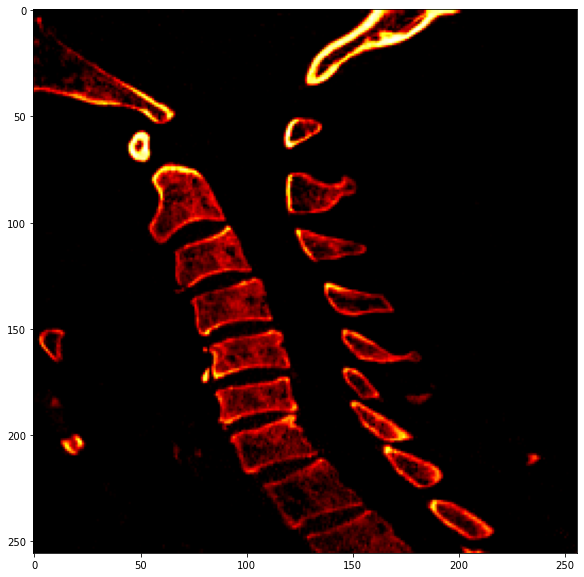

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(get_sample(not_bb_pos[670])[122])

In [31]:
pred = model.predict(get_sample(not_bb_pos[670])[108:138])

1/1 [==============================] - 9s 9s/step


In [39]:
pred[7]

array([[0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977],
       [0.41856977]], dtype=float32)

In [23]:
!mkdir final_model

In [25]:
model.save("./final_model/model")

INFO:tensorflow:Assets written to: ./final_model/model\assets


INFO:tensorflow:Assets written to: ./final_model/model\assets
